## Imports

In [91]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
import numpy as np
import pandas as pd
from os import path, listdir, environ
import wandb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib

## Config

In [26]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"]
    }

## Code

In [54]:
# To be moved to model_classes script when finished developing.

class HealthModel():
    def __init__(self, species, spatial_resolution, temporal_resolution, input_artifacts, met_variables):
        self.species = species
        self.spatial_resolution = spatial_resolution
        self.temporal_resolution = temporal_resolution
        self.input_artifacts = input_artifacts
        self.met_variables = met_variables

    def preprocess_and_log(self, train_size):
        with wandb.init(project="AQmortality", job_type="split-normalise-data") as run:
            df = pd.DataFrame()
            # use dataset artifacts
            for artifact in self.input_artifacts:
                data_artifact = run.use_artifact(f"{artifact}:latest")
                data_folder = data_artifact.download()
                if artifact == "met-resample":
                    for variable in self.met_variables:
                        file = f"{variable}.npz"
                        data = np.load(path.join(data_folder, file), allow_pickle=True)
                        if df.empty:
                            df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[variable])
                        else:
                            df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[variable]))
                else:
                    file = listdir(data_folder)[0]
                    data = np.load(path.join(data_folder, file), allow_pickle=True)
                    if df.empty:
                        df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[file.replace(".npz", "")])
                    else:
                        df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[file.replace(".npz", "")]))

            target_artifact = run.use_artifact("mortality-scaled:latest")
            target_folder = target_artifact.download()
            data = np.load(path.join(target_folder, "deaths.npz"), allow_pickle=True)
            df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"]*100000, columns=["deaths"]))
            df = df.dropna(axis=0)

            # make new train and test artifacts for regional scale data
            index = {"train": df.index[:int(len(df.index)*train_size)],
                    "test": df.index[int(len(df.index)*train_size):]}
            scaler = MinMaxScaler()
            x_scaler = scaler.fit(df.loc[index["train"]].drop("deaths", axis=1))
            for subset in ["train", "test"]:
                x = x_scaler.transform(df.loc[index[subset]].drop("deaths", axis=1))
                y = df.loc[index[subset]]["deaths"].values
                z = df.loc[index[subset]].index
                subset_data = wandb.Artifact(
                            f"xy_{subset}", type="dataset",
                            description=f"Input features (normalised) and targets for {subset}ing set.",
                            metadata={"input_shape":x.shape,
                                     "target_shape":y.shape,
                                     "species": self.species,
                                      "spatial_resolution": self.spatial_resolution,
                                      "temporal_resolution": self.temporal_resolution,
                                      "input_artifacts": self.input_artifacts,
                                      "met_variables": self.met_variables})
                with subset_data.new_file(subset + ".npz", mode="wb") as file:
                    np.savez(file, x=x, y=y, z=z)
                run.log_artifact(subset_data)
                
    def read_data(self, artifact):
        with wandb.init(project="AQmortality", job_type="read-data") as run:
            data_artifact = run.use_artifact(f"{artifact}:latest")
            data_folder = data_artifact.download()
            file = artifact.replace("xy_", "") + ".npz"
            data = np.load(path.join(data_folder, file), allow_pickle=True)
        return data["x"], data["y"]
    
    def train_and_log(self, model_type, config):
        with wandb.init(project="AQmortality", job_type="train-regional-model", config=config) as run:
            artifact = "xy_train"
            data_artifact = run.use_artifact(f"{artifact}:latest")
            data_folder = data_artifact.download()
            file = artifact.replace("xy_", "") + ".npz"
            data = np.load(path.join(data_folder, file), allow_pickle=True)
            x_train, y_train = data["x"], data["y"]
            if model_type == "linear-regressor":
                regressor = LinearRegression().fit(x_train, y_train)
                # log model training metrics
                wandb.log({"r_squared": r2_score(y_train, regressor.predict(x_train)),
                           "mean_squared_error": mean_squared_error(y_train, regressor.predict(x_train)),
                           "mean_absolute_percentage_error": self.mape_score(y_train, regressor.predict(x_train))
                          })

        # log trained model artifact – include input features description
            model = wandb.Artifact(
                            f"{model_type}", type="model",
                            description=f"{model_type} model.",
                            metadata={"input_shape":x_train.shape,
                                      "target_shape":y_train.shape,
                                      "species": self.species,
                                      "spatial_resolution": self.spatial_resolution,
                                      "temporal_resolution": self.temporal_resolution,
                                      "input_artifacts": self.input_artifacts,
                                      "met_variables": self.met_variables
                                      })
        
            with model.new_file("model.sav", mode="wb") as file:
                joblib.dump(regressor, file)
            run.log_artifact(model)
    
    
    def test_and_log(self, model_type):
        with wandb.init(project="AQmortality", job_type="test-regional-model") as run:
            data_dict = {}
            for subset in ["train", "test"]:
                data_artifact = run.use_artifact(f"xy_{subset}:latest")
                data_folder = data_artifact.download()
                file = f"{subset}.npz"
                data = np.load(path.join(data_folder, file), allow_pickle=True)
                data_dict.update({"x_"+subset: data["x"], "y_"+subset: data["y"], subset+"_dates": data["z"]})
            # use trained model artifact
            model_artifact = run.use_artifact(f"{model_type}:latest")
            model_folder = model_artifact.download()
            regressor = joblib.load(path.join(model_folder, "model.sav"))
    
        # test linear regression model
        # log model test metrics
            wandb.log({"r_squared": r2_score(data_dict["y_test"], regressor.predict(data_dict["x_test"])),
                       "mean_squared_error": mean_squared_error(data_dict["y_test"], regressor.predict(data_dict["x_test"])),
                       "mean_absolute_percentage_error": self.mape_score(data_dict["y_test"], regressor.predict(data_dict["x_test"]))
                      })
        return regressor, data_dict
    
    def mape_score(self, targets, predictions):
        zero_indices = np.where(targets == 0)
        targets_drop_zero = np.delete(targets, zero_indices)
        prediction_drop_zero = np.delete(predictions, zero_indices)
        mape = np.sum(np.abs(targets_drop_zero - prediction_drop_zero)/targets_drop_zero) * 100/len(targets_drop_zero)
        return mape

In [55]:
model = HealthModel(
    species=config["species"], 
    spatial_resolution=config["spatial_resolution"], 
    temporal_resolution=config["temporal_resolution"], 
    input_artifacts=config["input_artifacts"], 
    met_variables=config["met_variables"])

In [56]:
model.preprocess_and_log(train_size=config["train_size"])

In [51]:
model.train_and_log("linear-regressor", config)

r_squared,0.58492
mean_squared_error,0.05262
mean_absolute_percentage_error,9.30437
_runtime,9
_timestamp,1621510303
_step,0


r_squared,▁
mean_squared_error,▁
mean_absolute_percentage_error,▁
_runtime,▁
_timestamp,▁
_step,▁


In [57]:
regressor, data_dict = model.test_and_log("linear-regressor")

r_squared,-2.47872
mean_squared_error,0.18922
mean_absolute_percentage_error,24.12637
_runtime,10
_timestamp,1621510979
_step,0


r_squared,▁
mean_squared_error,▁
mean_absolute_percentage_error,▁
_runtime,▁
_timestamp,▁
_step,▁


In [95]:
df = pd.DataFrame()
for subset in ["train", "test"]:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"], "predicted":regressor.predict(data_dict[f"x_{subset}"])})
    if df.empty:
        df = subset_df.copy()
    else:
        df = df.append(subset_df)

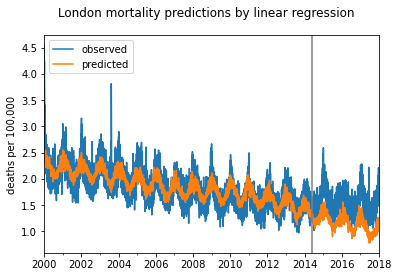

In [103]:
df.plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
plt.legend()
plt.ylabel("deaths per 100,000")
plt.suptitle("London mortality predictions by linear regression")
plt.show()